# Aerial Cactus Identification
Determine whether an image contains a columnar cactus

## Importing Library and Data
To begin, import the torch and torchvision frameworks and their libraries with numpy, pandas, and sklearn. Libraries and functions used in the code below include:
- transforms, for basic image transformations
- torch.nn.functional, which contains useful activation functions
- Dataset and Dataloader, PyTorch's data loading utility

In [2]:
import os
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

%matplotlib inline

In [6]:
os.getcwd()
# place the files in your IDE working dicrectory .
labels = pd.read_csv(r'dataset/train.csv')
submission = pd.read_csv(r'dataset/sample_submission.csv')

train_path = r'dataset/train/'
test_path = r'dataset/test/'

In [7]:
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [8]:
labels.tail()

,id,has_cactus
17495,ffede47a74e47a5930f81c0b6896479e.jpg,0
17496,ffef6382a50d23251d4bc05519c91037.jpg,1
17497,fff059ecc91b30be5745e8b81111dc7b.jpg,1
17498,fff43acb3b7a23edcc4ae937be2b7522.jpg,0
17499,fffd9e9b990eba07c836745d8aef1a3a.jpg,1


In [9]:
labels['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

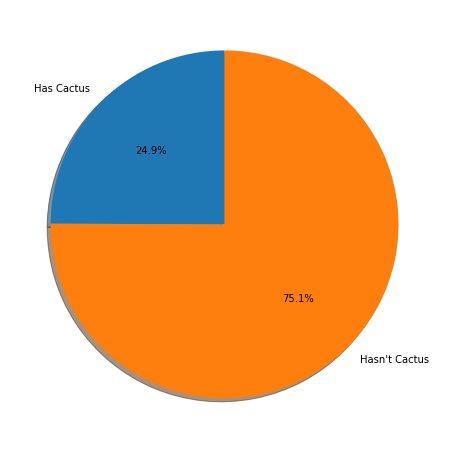

In [10]:
label = 'Has Cactus', 'Hasn\'t Cactus'
plt.figure(figsize = (8,8))
plt.pie(labels.groupby('has_cactus').size(), labels = label, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

As per the pie chart, the data is biased towards one class. Imbalanced data will affect the final results. We already have enough data for CNN to produce results, so there is no need for any data sampling or augmentation.

## Image Pre-processing
Images in a dataset do not usually have the same pixel intensity and dimensions. In this section, you will pre-process the dataset by standardizing the pixel values. The next required process is transforming raw images into tensors so that the algorithm can process them.

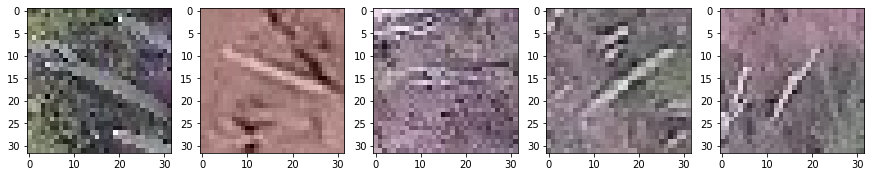

In [11]:
import matplotlib.image as img
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(labels[labels['has_cactus'] == 1]['id'][-5:]):
    path = os.path.join(train_path,idx)
    ax[i].imshow(img.imread(path))

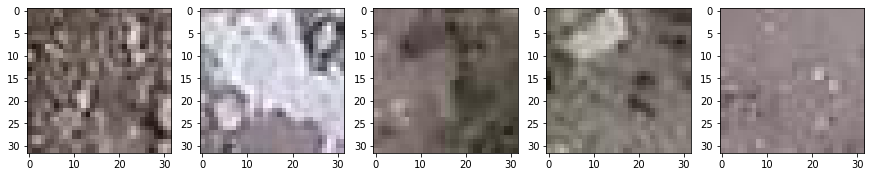

In [12]:
fig,ax = plt.subplots(1,5,figsize = (15,3))
for i,idx in enumerate(labels[labels['has_cactus'] == 0]['id'][:5]):
    path = os.path.join(train_path,idx)
    ax[i].imshow(img.imread(path))

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [14]:
class CactiDataset(Dataset):
    def __init__(self, data, path , transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_name,label = self.data[index]
        img_path = os.path.join(self.path, img_name)
        image = img.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

## Normalization
You can stack multiple image transformation commands in transform.Compose. Normalizing an image is an important step that makes model training stable and fast. In tranforms.Normalize() class, a list of means and standard deviations is sent in the form of a list. It uses this formula: x = (x -mean)/std, for x= 0 and x= 1

In [16]:
means = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(means,std)])

test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(means,std)])

valid_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(means,std)])

## Splitting the Dataset
How well the model can learn depends on the variety and volume of the data. We need to divide our data into a training set and a validation set using train_test_split.
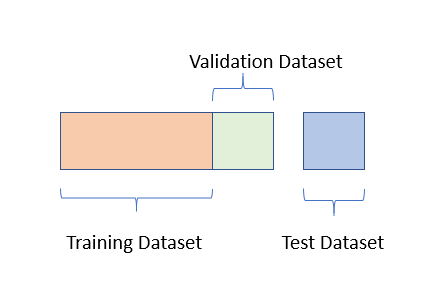
- Training dataset: The model learns from this dataset's examples. It fits a parameter to a classifier.
- Validation dataset: The examples in the validation dataset are used to tune the hyperparameters, such as learning rate and epochs. The aim of creating a validation set is to avoid large overfitting of the model. It is a checkpoint to know if the model is fitted well with the training dataset.
- Test dataset: This dataset test the final evolution of the model, measuring how well it has learned and predicted the desired output. It contains unseen, real-life data.

In [17]:
train, valid_data = train_test_split(labels, stratify=labels.has_cactus, test_size=0.2)

In [18]:
train_data = CactiDataset(train, train_path, train_transform )
valid_data = CactiDataset(valid_data, train_path, valid_transform )
test_data = CactiDataset(submission, test_path, test_transform )

In [19]:
# Hyper parameters

num_epochs = 35
num_classes = 2
batch_size = 25
learning_rate = 0.001

In [20]:
# CPU or GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In the code below, dataloader ombines a dataset and a sampler and provides an iterable over the given dataset. dataset()indicates which dataset to load form the available data.

In [21]:
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(dataset = valid_data, batch_size = batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle=False, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


training images
torch.Size([3, 32, 32])


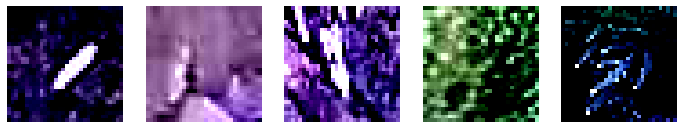

In [22]:
trainimages, trainlabels = next(iter(train_loader))

fig, axes = plt.subplots(figsize=(12, 12), ncols=5)
print('training images')
for i in range(5):
    axe1 = axes[i] 
    imshow(trainimages[i], ax=axe1, normalize=False)

print(trainimages[0].size())

## Designing a Convolution Neural Network (CNN)
If you try to recognize objects in a given image, you notice features like color, shape, and size that help you identify objects in images. The same technique is used by a CNN. The two main layers in a CNN are the convolution and pooling layer, where the model makes a note of the features in the image, and the fully connected (FC) layer, where classification takes place.
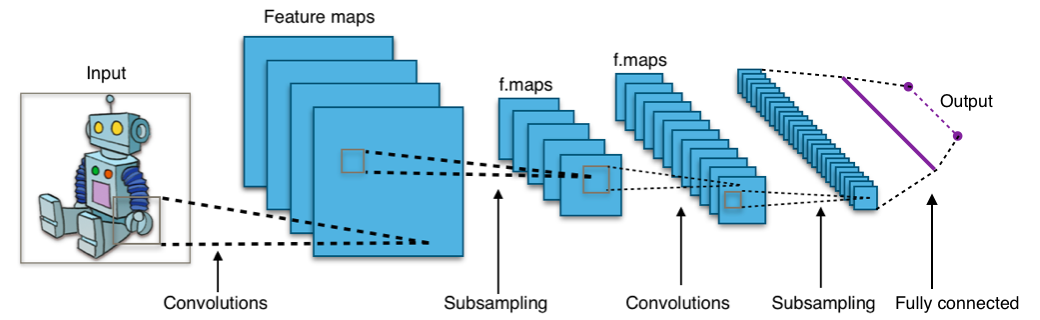

### Convolution Layer
Mathematically, convolution is an operation performed on two functions to produce a third function. Convolution is operating in speech processing (1 dimension), image processing (2 dimensions), and video processing (3 dimensions). The convolution layer forms a thick filter on the image.

The convolutional layer’s output shape is affected by the choice of kernel size, input dimensions, padding, and strides (number of pixels by which the window moves).

In this model, a 3x3 kernel size is used. It will have 27 weights and 1 bias.
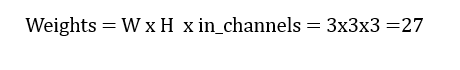

This is what happens behind the CNN.

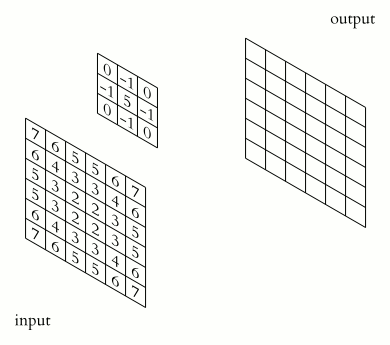

The factors that affect the convolutional layer’s output shape are the kernel size, input dimensions, padding and strides (no.of pixel by which the window moves). In this model 3x3 kernel filter is used. It will have 27 weights and 1 bias.

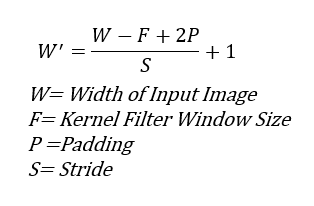

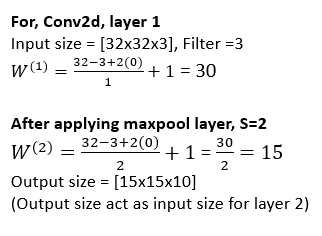

Similarly, carry out the calculation of layer 2.

### Pooling Layer
A drawback of a convolution feature map is that it records the exact position of features. Even the smallest development in the feature map will produce different results. This problem is solved by down sampling the feature map. It will be a lower version of the image with important features intact. In this model, max pooling is used. It calculates the maximum value of each patch of the feature map.

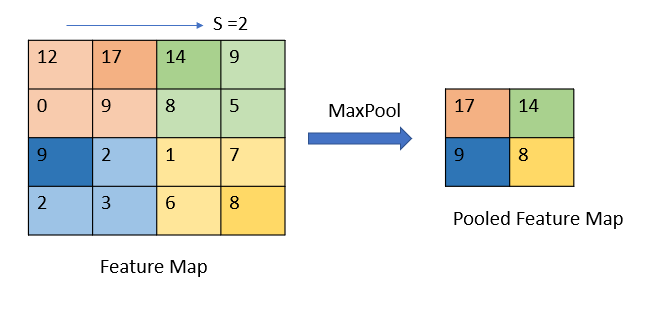

Some brief notes about important parameters of __init__ model and forward are stated below:

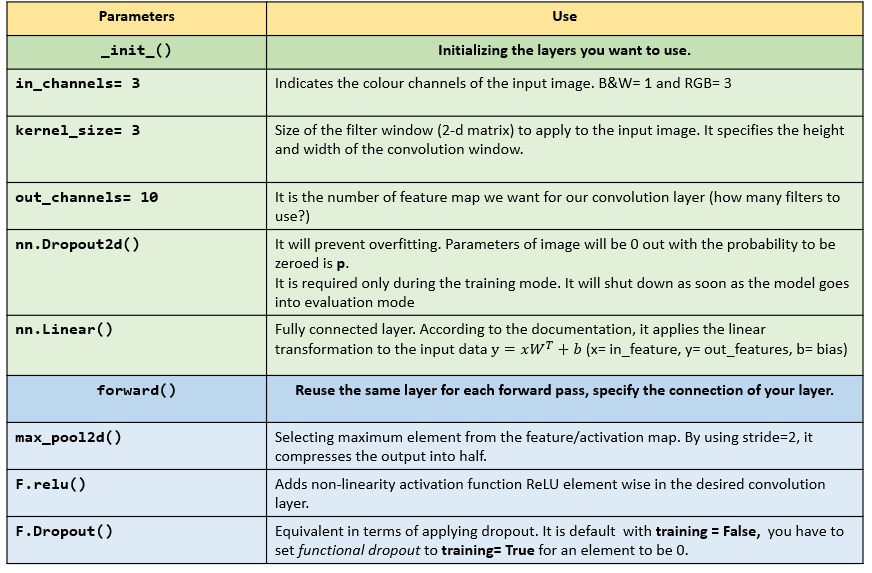

### Activation Layer
During forward propagation, activation function is used on each layer. The non-linearity transformation is introduced by the activation function. A neural network without an activation function is just a linear regression model, so it can not be ignored. Below is a list of activation functions.

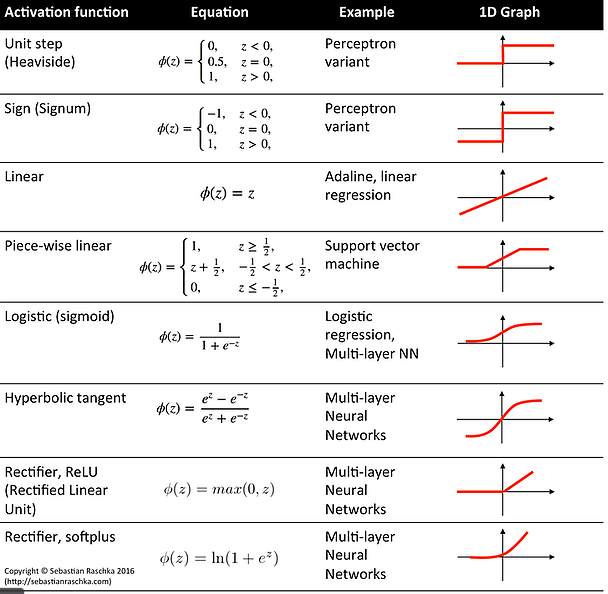

In [23]:
epochs = 35
batch_size = 25
learning_rate = 0.001

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(720, 1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [28]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=720, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)


### Loss
There are different types of losses implemented in machine learning. In this guide, cross-entropy loss is used. In this context, it is also known as log loss. Notice it has the same formula as that of likelihood, but it contains a log value.

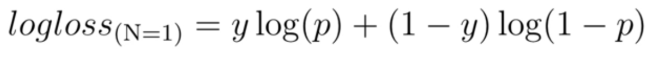

The best thing about this function is that if the prediction is 0, the first half goes away, and if the prediction is 1, the second half drops. With this, you can estimate of where your model can go wrong while predicting the label. Changes are to be made during training to minimize the loss.

### Optimization
Select any one optimizer algorithm available in the torch.optim package. The optimizers have some elements of the gradient descent. By changing the model parameters, like weights, and adding bias, the model can be optimized. The learning rate will decide how big the steps should be to change the parameters.

Calculate what a small change in each weight would do to the loss function (selecting the direction to reach minima).
Adjust each weight based on its gradient (i.e., take a small step in the determined direction).
Keep doing steps 1 and 2 until the loss function gets as low as possible.
Here, adaptive moment estimation (Adam) is used as an optimizer. It is a blend of RMSprop and stochastic gradient descent.

Loss function and optimization go hand-in-hand. Loss function checks whether the model is moving in the correct direction and making progress, whereas optimization improves the model to deliver accurate results.

In [29]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [30]:
%%time
# keeping-track-of-losses 
train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 0.185180 	Validation Loss: 0.083682
Epoch: 2 	Training Loss: 0.105858 	Validation Loss: 0.064755
Epoch: 3 	Training Loss: 0.085189 	Validation Loss: 0.059808
Epoch: 4 	Training Loss: 0.073833 	Validation Loss: 0.054659
Epoch: 5 	Training Loss: 0.070890 	Validation Loss: 0.045678
Epoch: 6 	Training Loss: 0.060144 	Validation Loss: 0.050426
Epoch: 7 	Training Loss: 0.063286 	Validation Loss: 0.043138
Epoch: 8 	Training Loss: 0.056380 	Validation Loss: 0.038590
Epoch: 9 	Training Loss: 0.057809 	Validation Loss: 0.048724
Epoch: 10 	Training Loss: 0.051787 	Validation Loss: 0.044775
Epoch: 11 	Training Loss: 0.044968 	Validation Loss: 0.037934
Epoch: 12 	Training Loss: 0.046303 	Validation Loss: 0.035370
Epoch: 13 	Training Loss: 0.048331 	Validation Loss: 0.032448
Epoch: 14 	Training Loss: 0.045099 	Validation Loss: 0.036461
Epoch: 15 	Training Loss: 0.040398 	Validation Loss: 0.035691
Epoch: 16 	Training Loss: 0.037531 	Validation Loss: 0.038016
Epoch: 17 	Traini

In [36]:
# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Val Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
torch.save(model.state_dict(), 'model.ckpt')

Val Accuracy of the model: 98.88571428571429 %


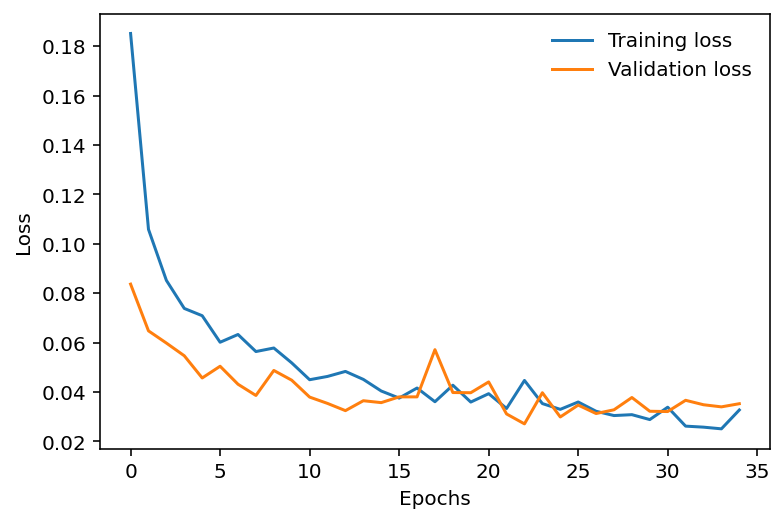

In [32]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [51]:
# test-the-model
preds = []
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        preds += predicted.tolist()

submit = pd.read_csv('dataset/sample_submission.csv')
submit['has_cactus'] = preds
submit.to_csv('submission.csv', index=False)